# Squared Exponential kernel Gaussian process - PriorVAE


This is a demo notebook to showcase the usage of PriorVAE model on a Gaussian process dataset which is generated using a SquaredExponential kernel.

In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer
from priorCVAE.losses import SquaredSumAndKL

import jax.config as config
config.update("jax_enable_x64", True)

### Configuration

In [2]:
args = {
        # architecture
        "input_dim" : 80,
        "hidden_dim": 60,
        "latent_dim": 40,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 4000,
        "learning_rate": 1e-3,
        "vae_var": 1.,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_mcmc_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data

We generate the data using an SquaredExponential kernel with lengthscale that is uniformly sampled. We plot a sample from the GP and plot the trajectories and lengthscales.

In [3]:
kernel = SquaredExponential()

gp_set = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=True) 

In [4]:
sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=1000)

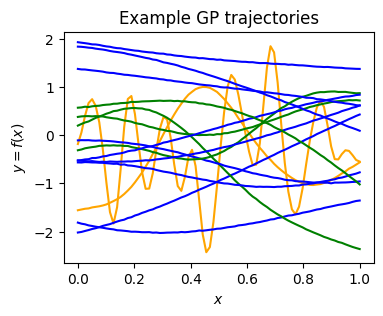

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if sample_ls_train[i] <= 0.2:
        col = 'orange'
    elif sample_ls_train[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(sample_x_train[i], sample_y_train[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Example GP trajectories')

plt.show()

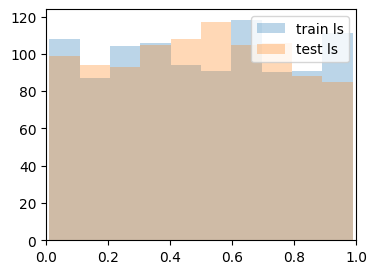

In [6]:
# Plot sample lengthscales
plt.figure(figsize=(4,3))
plt.hist(sample_ls_train[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_test[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()
plt.show()

### PriorVAE Model

We define the PriorVAE model, optimizer, and initialize the parameters of the model randomly.

In [7]:
out_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
latent_dim = args["latent_dim"]
batch_size = args["batch_size"]
num_iterations = args["num_iterations"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]
true_ls = args["true_ls"]

In [8]:
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)

### Train the model

Train the model and plot the train loss and the test loss.

In [9]:
trainer = VAETrainer(model, optimizer, loss=SquaredSumAndKL(vae_var=vae_var))
trainer.init_params(sample_y_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_set, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')


[    1] training loss: 7367.143, test loss: 86203.552
[   11] training loss: 5316.476, test loss: 55475.390
[   21] training loss: 5307.919, test loss: 49184.555
[   31] training loss: 4027.778, test loss: 43021.324
[   41] training loss: 3398.970, test loss: 36359.192
[   51] training loss: 3009.657, test loss: 30907.809
[   61] training loss: 3035.461, test loss: 27680.113
[   71] training loss: 2328.903, test loss: 25609.561
[   81] training loss: 2610.359, test loss: 24501.994
[   91] training loss: 2240.402, test loss: 22955.766
[  101] training loss: 2068.925, test loss: 22040.153
[  111] training loss: 1987.240, test loss: 21097.838
[  121] training loss: 1925.669, test loss: 20383.475
[  131] training loss: 1838.039, test loss: 20073.280
[  141] training loss: 1822.571, test loss: 19351.308
[  151] training loss: 1816.698, test loss: 19059.767
[  161] training loss: 1970.744, test loss: 18469.680
[  171] training loss: 1711.452, test loss: 18466.500
[  181] training loss: 1796.

[ 1541] training loss: 814.049, test loss: 9633.135
[ 1551] training loss: 906.778, test loss: 9603.863
[ 1561] training loss: 851.178, test loss: 9561.448
[ 1571] training loss: 776.456, test loss: 9591.615
[ 1581] training loss: 760.466, test loss: 9414.547
[ 1591] training loss: 1096.918, test loss: 9518.221
[ 1601] training loss: 1111.219, test loss: 9461.605
[ 1611] training loss: 945.671, test loss: 9463.007
[ 1621] training loss: 861.757, test loss: 9497.871
[ 1631] training loss: 874.948, test loss: 9514.305
[ 1641] training loss: 1026.540, test loss: 9386.505
[ 1651] training loss: 1034.611, test loss: 9414.585
[ 1661] training loss: 1024.707, test loss: 9506.298
[ 1671] training loss: 857.322, test loss: 9485.275
[ 1681] training loss: 855.028, test loss: 9413.998
[ 1691] training loss: 1021.840, test loss: 9427.147
[ 1701] training loss: 798.941, test loss: 9492.964
[ 1711] training loss: 1046.635, test loss: 9379.878
[ 1721] training loss: 944.571, test loss: 9425.924
[ 173

[ 3111] training loss: 917.752, test loss: 9062.439
[ 3121] training loss: 951.607, test loss: 9013.553
[ 3131] training loss: 982.634, test loss: 9119.707
[ 3141] training loss: 1031.395, test loss: 8988.357
[ 3151] training loss: 907.191, test loss: 9063.811
[ 3161] training loss: 993.360, test loss: 9109.804
[ 3171] training loss: 800.469, test loss: 9091.160
[ 3181] training loss: 782.610, test loss: 9016.923
[ 3191] training loss: 973.773, test loss: 9121.516
[ 3201] training loss: 764.320, test loss: 9073.880
[ 3211] training loss: 822.623, test loss: 9087.445
[ 3221] training loss: 775.397, test loss: 9087.339
[ 3231] training loss: 860.657, test loss: 9038.356
[ 3241] training loss: 831.664, test loss: 9087.575
[ 3251] training loss: 895.935, test loss: 9096.138
[ 3261] training loss: 735.807, test loss: 9070.626
[ 3271] training loss: 895.205, test loss: 9081.760
[ 3281] training loss: 868.860, test loss: 9076.373
[ 3291] training loss: 803.151, test loss: 9070.146
[ 3301] tra

Text(0.5, 1.0, 'Test loss')

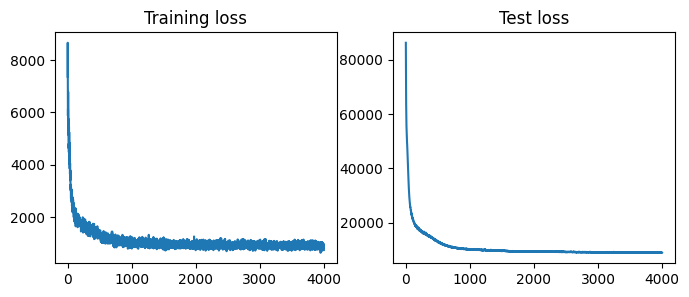

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(range(len(loss_vals)), loss_vals)
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals)), test_vals)
axs[1].set_title("Test loss")


### Trained Decoder

We plot a sample of trajectories from the trained decoder model.

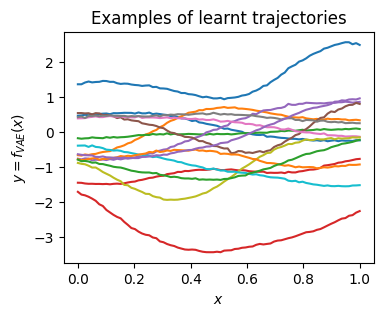

In [11]:
decoder_params = trainer.state.params['decoder']

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (batch_size, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim)
out = decoder.apply({'params': decoder_params}, z)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

### Inference with MCMC

We randomly generate observations from the GP.

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

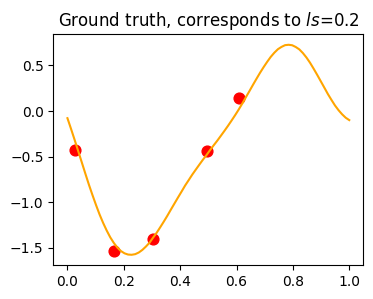

In [12]:
x = sample_x_train[0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=true_ls, variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

# add data to args. This is used by MCMC.
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

### Numpyro model

We define a Nupmyro model to run MCMC.

In [13]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -0.72      0.19     -0.71     -1.01     -0.41  17117.38      1.00
      f[1]     -0.74      0.19     -0.74     -1.05     -0.43  16861.38      1.00
      f[2]     -0.75      0.19     -0.74     -1.05     -0.44  17322.67      1.00
      f[3]     -0.77      0.19     -0.76     -1.08     -0.46  16905.91      1.00
      f[4]     -0.79      0.19     -0.78     -1.09     -0.47  17199.59      1.00
      f[5]     -0.82      0.18     -0.82     -1.12     -0.52  17079.03      1.00
      f[6]     -0.87      0.18     -0.87     -1.15     -0.57  17269.93      1.00
      f[7]     -0.90      0.17     -0.90     -1.18     -0.63  17475.22      1.00
      f[8]     -0.95      0.17     -0.95     -1.23     -0.68  17579.14      1.00
      f[9]     -0.98      0.16     -0.98     -1.25     -0.73  17250.22      1.00
     f[10]     -1.02      0.15     -1.02     -1.28     -0.78  17251.19      1.00
     f[11]     -1.07      0

Average ESS for all VAE-GP effects : 11816


## Plotting

We plot the trajectory after MCMC.

Text(0.5, 1.0, 'PriorVAE inference')

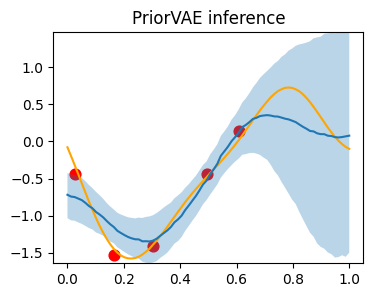

In [14]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(true_ls))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorVAE inference')